Extração(LLM) - Recomendação (RecSys) - Review (LLM) 

## Imports

### Dataset

In [83]:
import pandas as pd
import openai # API openai
import zipfile # Extrair .zip
import json # Trabalhar com JSON
import re
import pickle
import numpy as np
from tqdm import tqdm
from numpy import log2

from libs.extract import clean_data, build_interaction_df, create_sparse_matrix, get_ground_truth, ids_dataset_fuzzy, conv_to_text, responses_list_to_df, normalizar_scores_llm
from libs.model import EASE
from libs.metrics import comparar_orig_extracao, avaliar_orig, avaliar_llm


In [84]:
# Importando dados de treino e teste
with zipfile.ZipFile('../data/redial_dataset.zip', 'r') as z:
    z.extractall('../data/')

train_data = []
for line in open("../data/train_data.jsonl", "r"):
    train_data.append(json.loads(line))
print("Loaded {} train conversations".format(len(train_data)))


test_data = []
for line in open("../data/test_data.jsonl", "r"):
    test_data.append(json.loads(line))
print("Loaded {} test conversations".format(len(test_data)))

movies_w_mentions = pd.read_csv('../data/movies_with_mentions.csv')

Loaded 10006 train conversations
Loaded 1342 test conversations


In [85]:
test_data[232]

{'movieMentions': {'193168': 'Rush Hour  (1998)',
  '133381': 'The Juror (1996)',
  '112284': 'Ring  (1998)',
  '187028': 'It  (2017)',
  '118762': '21 Jump Street  (2012)'},
 'respondentQuestions': {'193168': {'suggested': 1, 'seen': 0, 'liked': 1},
  '133381': {'suggested': 1, 'seen': 2, 'liked': 2},
  '112284': {'suggested': 0, 'seen': 1, 'liked': 2},
  '187028': {'suggested': 0, 'seen': 0, 'liked': 2},
  '118762': {'suggested': 1, 'seen': 2, 'liked': 2}},
 'messages': [{'timeOffset': 0,
   'text': 'HI',
   'senderWorkerId': 997,
   'messageId': 209161},
  {'timeOffset': 1, 'text': 'hi', 'senderWorkerId': 1016, 'messageId': 209162},
  {'timeOffset': 5,
   'text': 'How are you?',
   'senderWorkerId': 997,
   'messageId': 209163},
  {'timeOffset': 7,
   'text': 'I like all sorts of movies',
   'senderWorkerId': 1016,
   'messageId': 209164},
  {'timeOffset': 8,
   'text': 'I am fine',
   'senderWorkerId': 1016,
   'messageId': 209165},
  {'timeOffset': 16,
   'text': 'Can you mention 

In [86]:
# Exemplo de conversa 
conversation = train_data[32]

# Mostrar de forma formatada
print("=== Conversa ID:", conversation["conversationId"], "===")
for msg in conversation["messages"]:
    sender = "Usuário 1" if msg["senderWorkerId"] == conversation["initiatorWorkerId"] else "Usuário 2"
    print(f"{sender}: {msg['text']}")

=== Conversa ID: 485 ===
Usuário 1: Hi can you help me find a musical
Usuário 2: hey what kind of movies interest you
Usuário 2: yes i would love to!
Usuário 1: I really like @127328 and @107350
Usuário 2: have you seen @172129 with Renee Zellwegger, Queen Latifa, and Catherine Zeta Jones
Usuário 2: I like @127328 too!
Usuário 2: oops, I meant @145997
Usuário 1: Yeah I have seen @145997 many times
Usuário 2: what about @124461 for something a little different or even @124268 which was more recent?
Usuário 1: I have not seen @124268 I think I may like that one
Usuário 2: The music is all from ABBA and it is so good
Usuário 2: I hope you will enjoy it as much as I do
Usuário 1: That is great that group does have some good music thanks for the help. Bye
Usuário 2: no problem bye


In [87]:
movie_mentions = conversation.get('movieMentions', {})

print(f"=== Conversa ID: {conversation['conversationId']} ===")

for msg in conversation["messages"]:
    sender = "User 1" if msg["senderWorkerId"] == conversation["initiatorWorkerId"] else "User 2"
    text = msg['text']
    
    # Substitui cada @movieId pelo título do filme
    for movie_id, movie_title in movie_mentions.items():
        text = text.replace(f'@{movie_id}', movie_title)
    
    print(f"{sender}: {text}")

=== Conversa ID: 485 ===
User 1: Hi can you help me find a musical
User 2: hey what kind of movies interest you
User 2: yes i would love to!
User 1: I really like Hairspray  (2007) and Sweeney Todd: The Demon Barber of Fleet Street  (2007)
User 2: have you seen Chicago 10  (2007) with Renee Zellwegger, Queen Latifa, and Catherine Zeta Jones
User 2: I like Hairspray  (2007) too!
User 2: oops, I meant Chicago  (2002)
User 1: Yeah I have seen Chicago  (2002) many times
User 2: what about White Christmas  (1954) for something a little different or even Mamma Mia!  (2008) which was more recent?
User 1: I have not seen Mamma Mia!  (2008) I think I may like that one
User 2: The music is all from ABBA and it is so good
User 2: I hope you will enjoy it as much as I do
User 1: That is great that group does have some good music thanks for the help. Bye
User 2: no problem bye


In [88]:
conversation = train_data[222]

# IDs de usuários
initiator_id = conversation["initiatorWorkerId"]
respondent_id = conversation["respondentWorkerId"]

print("ID do usuário que iniciou a conversa:", initiator_id)
print("ID do usuário que respondeu:", respondent_id)


ID do usuário que iniciou a conversa: 56
ID do usuário que respondeu: 60


## Tratamento e Limpeza dos datasets

In [89]:
clean_data(train_data)
clean_data(test_data)

✅ Conversas válidas restantes: 10005
🗑️ Conversas removidas: 1
✅ Conversas válidas restantes: 1342
🗑️ Conversas removidas: 0


### Substituiçao Errados

In [90]:
import re
import copy
import math
import numpy as np
import pandas as pd
from collections import defaultdict

# -----------------------------
# 0) Helpers: parsing & normalize
# -----------------------------

_YEAR_RE = re.compile(r"\((\d{4})\)\s*$")

def has_year(title: str) -> bool:
    if not isinstance(title, str):
        return False
    return _YEAR_RE.search(title.strip()) is not None

def extract_year(title: str):
    if not isinstance(title, str):
        return None
    m = _YEAR_RE.search(title.strip())
    return int(m.group(1)) if m else None

def base_title(title: str) -> str:
    """
    Remove trailing '(YYYY)' and normalize spaces.
    Example:
      'American Pie  (1999)' -> 'American Pie'
      'American Pie ' -> 'American Pie'
    """
    if not isinstance(title, str):
        return ""
    t = title.strip()
    t = re.sub(r"\(\d{4}\)\s*$", "", t).strip()
    t = re.sub(r"\s+", " ", t).strip()
    return t

def norm_title(title: str) -> str:
    """Lower + remove extra whitespace (keeps punctuation)."""
    return base_title(title).lower().strip()

def safe_get_flags(conv, key):
    data = conv.get(key, {})
    return {} if isinstance(data, list) else data

# -----------------------------
# 1) Build candidate index from movies_w_mentions
# -----------------------------

def build_candidates_index(movies_w_mentions: pd.DataFrame):
    """
    Expects columns: movieId, movieName, nbMentions
    Returns:
      - base_norm -> list[{id, name, year, nb}]
      - id -> {name, year, nb, base_norm}
    """
    idx = defaultdict(list)
    by_id = {}

    required = {"movieId", "movieName"}
    missing = required - set(movies_w_mentions.columns)
    if missing:
        raise ValueError(f"movies_w_mentions is missing columns: {missing}")

    # nbMentions optional (fallback to 0)
    for _, row in movies_w_mentions.iterrows():
        mid = str(row["movieId"])
        name = row["movieName"]
        nb = int(row["nbMentions"]) if "nbMentions" in movies_w_mentions.columns and pd.notna(row["nbMentions"]) else 0

        y = extract_year(name)
        bnorm = norm_title(name)

        rec = {"id": mid, "name": name, "year": y, "nb": nb, "base_norm": bnorm}
        by_id[mid] = rec

        # Only index candidates that HAVE YEAR (you requested "substituir por filmes com data")
        if y is not None:
            idx[bnorm].append(rec)

    return idx, by_id

# -----------------------------
# 2) Scoring rule you asked for:
#    - if multiple candidates:
#        center_year = median(years of other movies w/ year in the conversation)
#        pick argmin |year-center| - 0.5*log1p(nbMentions)
#    - if no center_year: pick max nbMentions
# -----------------------------

def choose_candidate(candidates, center_year):
    """
    candidates: list of recs with year != None
    center_year: int or None
    """
    if not candidates:
        return None

    if center_year is None:
        # pick most mentioned
        return max(candidates, key=lambda r: (r["nb"], r["year"] if r["year"] is not None else -1))

    def score(r):
        # abs distance - 0.5*log1p(nbMentions)
        return abs(r["year"] - center_year) - 0.5 * math.log1p(max(r["nb"], 0))

    # minimize score, tie-break by higher nbMentions
    return min(candidates, key=lambda r: (score(r), -r["nb"]))

# -----------------------------
# 3) Merge flags safely when old_id -> new_id
#    (Optional but recommended to avoid losing labels)
# -----------------------------

def merge_question_flags(old_flags: dict, new_flags: dict):
    """
    Both dicts can have keys: suggested, seen, liked
    We'll keep "stronger" signal:
      liked order: 1 (positive) > 0 (negative) > 2/None (unknown)
      seen  order: 1 (seen)     > 0 (not seen) > 2/None (unknown)
      suggested: max
    """
    def pick(order, a, b):
        # order: list of preferred values
        for v in order:
            if a == v or b == v:
                return v
        # fallback: keep b if exists else a
        return b if b is not None else a

    out = {}
    old_flags = old_flags or {}
    new_flags = new_flags or {}

    out["suggested"] = max(old_flags.get("suggested", 0), new_flags.get("suggested", 0))

    out["liked"] = pick([1, 0, 2], old_flags.get("liked", None), new_flags.get("liked", None))
    out["seen"]  = pick([1, 0, 2], old_flags.get("seen", None),  new_flags.get("seen", None))

    # keep any extra fields if exist
    for k, v in old_flags.items():
        if k not in out:
            out[k] = v
    for k, v in new_flags.items():
        if k not in out:
            out[k] = v

    return out

# -----------------------------
# 4) Apply replacement inside ONE conversation
# -----------------------------

def get_center_year_from_conv(conv, exclude_ids=None):
    """
    Median year of OTHER movies in movieMentions that have year in the title.
    exclude_ids: set of ids (strings) to ignore when computing center.
    """
    exclude_ids = exclude_ids or set()
    mentions = conv.get("movieMentions", {}) or {}
    years = []
    for mid, title in mentions.items():
        mid = str(mid)
        if mid in exclude_ids:
            continue
        y = extract_year(title)
        if y is not None:
            years.append(y)
    return int(np.median(years)) if years else None

def apply_replacement_in_conv(conv, old_id: str, new_rec: dict):
    """
    Mutates conv in-place:
      - movieMentions: replace key old_id -> new_id (and set title to candidate name)
      - initiatorQuestions/respondentQuestions: move/merge flags
      - messages: replace '@old_id' -> '@new_id'
    """
    new_id = str(new_rec["id"])
    new_name = new_rec["name"]

    # 1) movieMentions
    mentions = conv.get("movieMentions", {})
    if isinstance(mentions, dict):
        # remove old, add/overwrite new
        if old_id in mentions:
            mentions.pop(old_id, None)
        # Ensure new appears with name WITH YEAR
        mentions[new_id] = new_name
        conv["movieMentions"] = mentions

    # 2) Questions flags: initiatorQuestions, respondentQuestions
    for key in ("initiatorQuestions", "respondentQuestions"):
        q = safe_get_flags(conv, key)
        if not q:
            # if list or empty, just skip
            continue
        old_flags = q.get(old_id)
        new_flags = q.get(new_id)
        if old_flags is not None or new_flags is not None:
            merged = merge_question_flags(old_flags or {}, new_flags or {})
            q[new_id] = merged
            q.pop(old_id, None)
            conv[key] = q

    # 3) Messages: replace @old_id with @new_id
    msgs = conv.get("messages", [])
    if isinstance(msgs, list):
        old_tag = f"@{old_id}"
        new_tag = f"@{new_id}"
        for m in msgs:
            txt = m.get("text")
            if isinstance(txt, str) and old_tag in txt:
                m["text"] = txt.replace(old_tag, new_tag)
        conv["messages"] = msgs

    return conv

# -----------------------------
# 5) Main: fix_missing_years_in_dataset (NO mutation of original)
# -----------------------------

def fix_missing_years_in_dataset(
    dataset,
    movies_w_mentions: pd.DataFrame,
    verbose=True,
    max_log_examples=10
):
    """
    Returns:
      fixed_dataset, report

    Rules:
      - if missing-year title has no substitute: skip
      - if exactly 1 substitute: replace
      - if multiple substitutes:
          center_year = median(years of other movies with year in THIS conversation)
          if center_year exists: choose min |year-center| - 0.5*log1p(nbMentions)
          else: choose max nbMentions
    """
    cand_idx, by_id = build_candidates_index(movies_w_mentions)
    fixed = copy.deepcopy(dataset)

    report = {
        "total_convs": len(dataset),
        "missing_year_items": 0,
        "replaced": 0,
        "skipped_no_candidate": 0,
        "skipped_bad_mentions": 0,
        "multi_candidate": 0,
        "examples": {
            "skipped_no_candidate": [],
            "multi_candidate_choices": [],
            "replaced": [],
        }
    }

    for conv in fixed:
        mentions = conv.get("movieMentions", {})
        if not isinstance(mentions, dict) or not mentions:
            report["skipped_bad_mentions"] += 1
            continue

        # find ids with missing year in their movieMentions title
        missing_ids = []
        for mid, title in mentions.items():
            mid = str(mid)
            if isinstance(title, str) and not has_year(title):
                missing_ids.append(mid)

        if not missing_ids:
            continue

        # process each missing id (one by one)
        for old_id in missing_ids:
            old_title = mentions.get(old_id)
            if not isinstance(old_title, str):
                continue

            report["missing_year_items"] += 1

            bnorm = norm_title(old_title)
            candidates = cand_idx.get(bnorm, [])

            if not candidates:
                report["skipped_no_candidate"] += 1
                if len(report["examples"]["skipped_no_candidate"]) < max_log_examples:
                    report["examples"]["skipped_no_candidate"].append({
                        "conversationId": conv.get("conversationId"),
                        "old_id": old_id,
                        "old_title": old_title
                    })
                continue

            # compute center_year excluding this missing movie id
            center_year = get_center_year_from_conv(conv, exclude_ids={old_id})

            chosen = None
            if len(candidates) == 1:
                chosen = candidates[0]
            else:
                report["multi_candidate"] += 1
                chosen = choose_candidate(candidates, center_year)

                if len(report["examples"]["multi_candidate_choices"]) < max_log_examples:
                    report["examples"]["multi_candidate_choices"].append({
                        "conversationId": conv.get("conversationId"),
                        "old_id": old_id,
                        "old_title": old_title,
                        "center_year": center_year,
                        "candidates": [(c["id"], c["name"], c["year"], c["nb"]) for c in candidates],
                        "chosen": (chosen["id"], chosen["name"], chosen["year"], chosen["nb"]) if chosen else None
                    })

            if chosen is None:
                report["skipped_no_candidate"] += 1
                continue

            # If chosen id equals old id, nothing to do (rare)
            if str(chosen["id"]) == str(old_id):
                continue

            # Apply replacement in conv
            apply_replacement_in_conv(conv, str(old_id), chosen)
            report["replaced"] += 1

            if len(report["examples"]["replaced"]) < max_log_examples:
                report["examples"]["replaced"].append({
                    "conversationId": conv.get("conversationId"),
                    "old_id": old_id,
                    "old_title": old_title,
                    "new_id": str(chosen["id"]),
                    "new_title": chosen["name"],
                    "center_year": center_year
                })

            # update mentions ref (since we mutated it)
            mentions = conv.get("movieMentions", {})

    if verbose:
        print("=" * 70)
        print("✅ fix_missing_years_in_dataset — Report")
        print("=" * 70)
        print(f"Convs:                 {report['total_convs']}")
        print(f"Missing-year items:     {report['missing_year_items']}")
        print(f"Replaced:               {report['replaced']}")
        print(f"Multi-candidate cases:  {report['multi_candidate']}")
        print(f"Skipped (no candidate): {report['skipped_no_candidate']}")
        print(f"Skipped (bad mentions): {report['skipped_bad_mentions']}")
        print("=" * 70)

    return fixed, report

# -----------------------------
# 6) Convenience: show which ones were skipped
# -----------------------------

def show_skipped_cases(report, n=10):
    print("\n--- Skipped: no candidate ---")
    for ex in report["examples"]["skipped_no_candidate"][:n]:
        print(ex)

    print("\n--- Multi-candidate choices ---")
    for ex in report["examples"]["multi_candidate_choices"][:n]:
        print(ex)

    print("\n--- Replaced examples ---")
    for ex in report["examples"]["replaced"][:n]:
        print(ex)

# -----------------------------
# 7) USAGE EXAMPLE
# -----------------------------
# movies_w_mentions_df = pd.read_csv("movies_w_mentions.csv")  # you already have it
# fixed_test_data, fix_report = fix_missing_years_in_dataset(test_data, movies_w_mentions_df, verbose=True)
# show_skipped_cases(fix_report, n=10)


test_data, fix_report = fix_missing_years_in_dataset(test_data, movies_w_mentions, verbose=True)
train_data, fix_report = fix_missing_years_in_dataset(train_data, movies_w_mentions, verbose=True)

show_skipped_cases(fix_report, n=10)

✅ fix_missing_years_in_dataset — Report
Convs:                 1342
Missing-year items:     322
Replaced:               72
Multi-candidate cases:  7
Skipped (no candidate): 250
Skipped (bad mentions): 0
✅ fix_missing_years_in_dataset — Report
Convs:                 10005
Missing-year items:     3026
Replaced:               575
Multi-candidate cases:  83
Skipped (no candidate): 2451
Skipped (bad mentions): 0

--- Skipped: no candidate ---
{'conversationId': '395', 'old_id': '204322', 'old_title': 'South Park'}
{'conversationId': '418', 'old_id': '166069', 'old_title': 'Kill Bill'}
{'conversationId': '426', 'old_id': '104253', 'old_title': 'The Perks of Being a Wallflower '}
{'conversationId': '458', 'old_id': '125954', 'old_title': 'Star Trek: Of Gods and Men'}
{'conversationId': '463', 'old_id': '88960', 'old_title': 'The Naked Gun'}
{'conversationId': '475', 'old_id': '183056', 'old_title': 'The Big Lebowski'}
{'conversationId': '484', 'old_id': '103291', 'old_title': 'Eddie Murphy De

## Extração de itens e Montagem Matriz Usuário-Item (Offline)

### DF offline

In [91]:
def extract_interactions(conv, conv_idx):
    """
    1. Usa movieMentions (Robustez de extração).
    2. Define User = Índice da Conversa (Session-based puro: 0, 1, 2...).
    3. Input Permissivo: Aceita 1 (Like) e 2 (Mention/Did not say) para densidade.
    """
    rows = []
    
    # MUDANÇA AQUI: O ID do usuário passa a ser o índice sequencial da lista
    # Isso garante unicidade absoluta por sessão (Session-based)
    user_id = conv_idx
    
    # O "ouro" da extração textual
    mentions = conv.get("movieMentions", {})
    
    # Metadados para filtrar dislikes
    init_q = conv.get("initiatorQuestions", {})


    # Helper para checar sentimento (Ajustado para Input Permissivo)
    def is_valid_input(mid_str):
        # Se não tem metadados (init_q), assumimos que a menção é válida (Neutro/2 implícito)
        if mid_str not in init_q:
            return True 
            
        val = init_q[mid_str].get('liked')
        
        # Se for 1 (like), retorna True
        if val == 1:
            return True
            
        return False

    if isinstance(mentions, dict):
        for movie_id_str in mentions.keys():
            try:
                # CRAG: "exclude these items [negatively mentioned]" 
                if is_valid_input(movie_id_str):
                    rows.append((user_id, int(movie_id_str), 1))
                
            except ValueError:
                continue
                
    return rows

# NAO SEI, VER
def build_interaction_df(dataset):
    all_rows = []
    
    # MUDANÇA AQUI: Usamos enumerate para gerar o ID sequencial (0, 1, 2...)
    # Exatamente como "for instance in instances", mas capturando o índice.
    
    for idx, conv in tqdm(enumerate(dataset), total=len(dataset)):
        # Passamos 'conv' e o 'idx' para a função
        all_rows.extend(extract_interactions(conv, idx))
        
    df = pd.DataFrame(all_rows, columns=["userId", "movieId", "rating"])
    
    # Remove duplicatas (se o filme foi mencionado 2x na mesma conversa)
    df = df.drop_duplicates()
    
    return df   


In [92]:

# --- GERAR DATAFRAMES DE INTERAÇÕES ---
print("Extraindo dados com metodologia Robusta (Menções)...")
df_train = build_interaction_df(train_data)
df_test = build_interaction_df(test_data)



print(df_train.head())
print(df_train.shape)

print(df_test.head())
print(df_test.shape)


#(5684, 3)

Extraindo dados com metodologia Robusta (Menções)...


100%|██████████| 1342/1342 [00:00<00:00, 186716.51it/s]

   userId  movieId  rating
0       0   203371       1
1       0    84779       1
2       0   122159       1
3       0   151313       1
4       0   191602       1
(43065, 3)
   userId  movieId  rating
0       0   111776       1
1       0   151656       1
2       0   134643       1
3       0    94688       1
4       1   125431       1
(5774, 3)


#### Filtrar por interações



In [93]:
# movie_counts = df_train['movieId'].value_counts()
# popular_movies = movie_counts[movie_counts >= 0].index.tolist()
# df_train = df_train[df_train['movieId'].isin(popular_movies)]
# df_test  = df_test[df_test['movieId'].isin(popular_movies)]

print(df_train.head())
print(df_train.shape)

print(df_test.head())
print(df_test.shape)

# (42320, 3)
# (5684, 3)



   userId  movieId  rating
0       0   203371       1
1       0    84779       1
2       0   122159       1
3       0   151313       1
4       0   191602       1
(43065, 3)
   userId  movieId  rating
0       0   111776       1
1       0   151656       1
2       0   134643       1
3       0    94688       1
4       1   125431       1
(5774, 3)


### Matrix Factorization

In [94]:
from scipy.sparse import csr_matrix
# CERTO, NAO MUDAR
def create_sparse_matrix(df, user_mapper, movie_mapper, shape):
    """
        Cria matriz esparsa a partir de DataFrame
        user_mapper e movie_mapper são dicionarios do mapeamento
    """

    df_mapped = df.copy()

    # Faz mapeamento pois matrizes esparsas só aceitam índices inteiros começando em 0, e nao podem ser enormes
    
    df_mapped['user_index'] = df_mapped['userId'].map(user_mapper)#.astype('Int64')
    df_mapped['movie_index'] = df_mapped['movieId'].map(movie_mapper)#.astype('Int64')
    
    # remove linhas com NaN em índices ou rating inválido
    df_mapped = df_mapped.dropna(subset=['user_index', 'movie_index', 'rating'])
    df_mapped = df_mapped[df_mapped['rating'] > 0]

    # Remove duplicatas
    df_mapped = df_mapped.drop_duplicates(subset=['user_index', 'movie_index'], keep='last')
 
    # Cria matriz esparsa
    matrix = csr_matrix(
        (df_mapped['rating'].astype(float),
         (df_mapped['user_index'], #.astype('Int64')
          df_mapped['movie_index'])),#.astype('Int64')
        shape=shape
    )
    return matrix

In [95]:
#Utility matrix (user-item)

np.random.seed(42)

#all_data = pd.concat([df_train, df_test]) # Concatena train + test para garantir que todos os IDs estejam mapeados

user_ids = sorted(df_train['userId'].unique())
movie_ids = sorted(df_train['movieId'].unique())

user_mapper = {u: i for i, u in enumerate(user_ids)}
movie_mapper = {m: i for i, m in enumerate(movie_ids)}

n_users = len(user_mapper)
n_movies = len(movie_mapper)



train_user_item_sparse = create_sparse_matrix(df_train, user_mapper, movie_mapper, (n_users, n_movies))


train_item_user_sparse = train_user_item_sparse.T.tocsr()








In [96]:
nonzero_cols = train_user_item_sparse[:10].nonzero()[1]
unique_cols = np.unique(nonzero_cols)

# pegar apenas os 6 primeiros filmes relevantes
selected_cols = unique_cols[:6]

# recorte da matriz
small_matrix = train_user_item_sparse[:10, selected_cols].toarray()

df_view = pd.DataFrame(
    small_matrix,
    columns=[f"Movie_{c}" for c in selected_cols],
    index=[f"User_{i}" for i in range(10)]
)

print(df_view)




        Movie_175  Movie_303  Movie_359  Movie_385  Movie_543  Movie_633
User_0        0.0        0.0        0.0        1.0        0.0        0.0
User_1        0.0        0.0        0.0        0.0        0.0        0.0
User_2        1.0        0.0        1.0        0.0        0.0        1.0
User_3        0.0        0.0        0.0        0.0        0.0        0.0
User_4        0.0        0.0        0.0        0.0        0.0        0.0
User_5        0.0        0.0        0.0        0.0        0.0        0.0
User_6        0.0        0.0        0.0        0.0        0.0        0.0
User_7        0.0        0.0        1.0        0.0        0.0        0.0
User_8        0.0        0.0        0.0        0.0        0.0        0.0
User_9        0.0        1.0        0.0        0.0        1.0        0.0


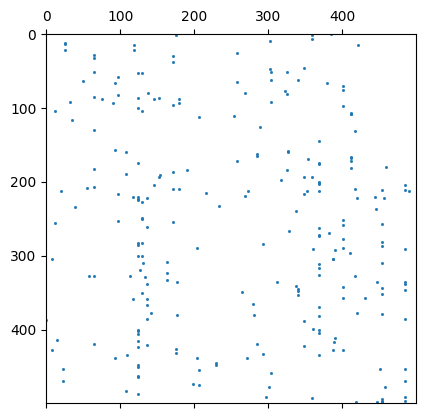

In [97]:
import matplotlib.pyplot as plt
plt.spy(train_user_item_sparse[:500, :500], markersize=1)
plt.show()


In [98]:
import numpy as np

def matrix_stats(M):


    print(f"Dimensões (usuários x itens): {M.shape}")
    print(f"Número total de elementos: {M.shape[0] * M.shape[1]:,}")
    
    # Elementos não nulos
    nnz = M.nnz

    # Densidade / Sparsidade
    density = nnz / (M.shape[0] * M.shape[1])
    print(f"Densidade: {density:.6f}")
    print(f"Esparsidade: {1 - density:.6f}")


    print(f"Média dos ratings: {M.data.mean():.2f}")


# Chamada:
matrix_stats(train_user_item_sparse)


Dimensões (usuários x itens): (9881, 5338)
Número total de elementos: 52,744,778
Densidade: 0.000816
Esparsidade: 0.999184
Média dos ratings: 1.00


In [99]:


with open("./variables/train_user_item_sparse.pkl", "wb") as f:
    pickle.dump(train_user_item_sparse, f)



In [100]:
with open("./variables/train_user_item_sparse.pkl", "rb") as f:
    train_user_item_sparse = pickle.load(f)


    

## Extração de Itens (LLM)

### Chave API Open AI

In [124]:
from openai import OpenAI
import asyncio
from openai import AsyncOpenAI
from dotenv import load_dotenv
import os


In [127]:
#Chave API
load_dotenv() 
API_KEY = os.getenv("API_KEY")

client = OpenAI(api_key=API_KEY)
async_client = AsyncOpenAI(api_key=API_KEY)

In [29]:

response = client.chat.completions.create(
    model="gpt-3.5-turbo",
    messages=[
        {"role": "user", "content": "oi, digite 112233 e uma frase qualquer"}
    ]
)

print(response.choices[0].message.content)




112233 - A vida é feita de momentos únicos e inesquecíveis.


### Dataset: Ids -> Filmes

In [106]:

# Troca ids por nome dos filmes

import copy

def id_to_title(dataset):
  
    dataset_titled = copy.deepcopy(dataset)

    # Acessando conversa dentro das mensagens
    for conv in dataset_titled:
        message = conv.get("messages", {}) 
        mentions = conv.get("movieMentions", {})
        
        # Acessando texto dentro da conversa 
        for text in message:
            utt = text.get("text", {})
            #print(text)
            
            # Itera filmes mencionados
            for id, title in mentions.items(): # Mapeando id nome
                tag = f"@{id}"
                if tag in utt:
                    utt = utt.replace(tag,title) # Trocando id por filme
                    #print(utt_new)
                    
                    
            # Trocando o texto
            text["text"] = utt

                
    return dataset_titled

    
train_data_titled = id_to_title(train_data)   
test_data_titled = id_to_title(test_data)   


test_data_titled[42]



{'movieMentions': {'119144': 'Wonder Woman  (2017)',
  '77610': 'Sky High  (2003)',
  '133236': 'X-Men: Apocalypse (2016)',
  '177915': 'Uncle Buck',
  '134885': 'The Hunger Games  (2012)',
  '100750': 'The Hunger Games: Catching Fire (2013)',
  '181715': 'Logan  (2017)'},
 'respondentQuestions': {'119144': {'suggested': 1, 'seen': 0, 'liked': 1},
  '77610': {'suggested': 0, 'seen': 1, 'liked': 1},
  '133236': {'suggested': 1, 'seen': 2, 'liked': 2},
  '177915': {'suggested': 1, 'seen': 2, 'liked': 2},
  '134885': {'suggested': 1, 'seen': 1, 'liked': 1},
  '100750': {'suggested': 1, 'seen': 1, 'liked': 1},
  '181715': {'suggested': 1, 'seen': 0, 'liked': 2}},
 'messages': [{'timeOffset': 0,
   'text': 'Hi there are you interested in some classic comedies?',
   'senderWorkerId': 959,
   'messageId': 205056},
  {'timeOffset': 17,
   'text': 'I am actually looking for movies for my 12 yr olds sleepover',
   'senderWorkerId': 979,
   'messageId': 205057},
  {'timeOffset': 22,
   'text': 'T

### Formatação Conversa

In [31]:

# Formatar conversa para envio para LLM. Imitando ao maximo o que seria em um exemplo real
# quem mandou a mensagem e seu conteudo






test_data_formatted = conv_to_text(test_data_titled)
print(test_data_formatted[232])




# {'movieMentions': {'111776': 'Super Troopers (2001)',
#   '91481': 'Beverly Hills Cop (1984)',
#   '151656': 'Police Academy  (1984)',
#   '134643': 'American Pie  (1999)',
#   '192131': 'American Pie ',
#   '124771': '48 Hrs. (1982)',
#   '94688': 'Police Academy 2: Their First Assignment (1985)',
#   '101794': 'Lethal Weapon (1987)'},


#  'respondentQuestions': {'111776': {'suggested': 0, 'seen': 1, 'liked': 1}, OK
#   '91481': {'suggested': 1, 'seen': 2, 'liked': 2},
#   '151656': {'suggested': 1, 'seen': 0, 'liked': 1}, OK
#   '134643': {'suggested': 0, 'seen': 1, 'liked': 1},
#   '192131': {'suggested': 0, 'seen': 1, 'liked': 1},
#   '124771': {'suggested': 1, 'seen': 2, 'liked': 2},
#   '94688': {'suggested': 1, 'seen': 0, 'liked': 1},
#   '101794': {'suggested': 1, 'seen': 0, 'liked': 2}},


System: HI
User: hi
System: How are you?
User: I like all sorts of movies
User: I am fine
User: Can you mention some?
User: I like comedu
System: Okay what about Rush Hour  (1998)
User: comedy and action
User: Yes good suggestion!
System: Good!
User: I also like scary ones too
User: What else?
System: What about 21 Jump Street  (2012)
User: Should I see It  (2017) ?
System: Im not a horror fan!
User: Ok I can watch that. It's been so long ago
System: Yeah for me too
User: Good to watch on friday night lol
User: and eat popcorn.
System: Have fun with that!
User: Sometimes I will watch Ring  (1998)
User: What other movies you can tell me to watch?
System: what about The Juror (1996)
System: Its been a long time for me
User: great!! thanks bye!
System: Bye


### Extração

#### Prompt

In [41]:
# PROMPT_LLM_EXTRACTION = """
# Pretend you are a data extraction system for a movie recommender.

# You will be given a full conversation between a user and a system. 
# Each line begins with User: or System:

# Your task is to extract movies that represent the USER'S PREFERENCES.

# CRITICAL LOGIC:
# 2. VERY POSITIVE (Really Likes/Accept Well): If the user really likes, enthusiastically accepts a suggestion, or wants to watch very much a movie -> (Attitude = 2).
# 1. POSITIVE (Likes/Accepts): If the user likes, accepts a suggestion, or wants to watch a movie -> (Attitude = 1).
# 0. NEUTRAL (Does Not Care): If the user does not care, does not explicitly like or dislike or does not express opinion a movie -> (Attitude = 0).
# -1 NEGATIVE (Does Not Like/Rejects): If the user explicitly dislikes, rejects, or does not likes a movie -> (Attitude = -1).
# -2 VERY NEGATIVE (Hates/Rejects Strongly) If the user hates, strongly dislikes or dispises a movie -> (Attitude = -2)

# OUTPUT FORMAT:
# Output ONLY the Exact Movie Title and the value of the attitude.
# Format: Movie Title####X

# IMPORTANT RULES:
# 1. Focus ONLY on the User's reaction. Do NOT infer preference just because the System suggested it.
# 2. The final attitude must reflect the user's LAST explicit opinion.
# 3. Each movie must appear ONLY ONCE.
# 4. Only  give the neutral rating if the user dos not mention the item in the dialog.
# 5. The users opinion must only be about movies suggested by the system. Do not include movies the user mentioned by themselves.

# Conversation:
# {conversation_text}


# Example output format:
# Police Academy 2: Their First Assignment (1985)####2
# Lethal Weapon (1987)####1
# The Mummy (1999)####0
# """

PROMPT_LLM_EXTRACTION = """
Pretend you are a data extraction system for a movie recommender.

You will be given a full conversation between a user and a system. 
Each line begins with User: or System:

Your task is to extract movies mentioned in the dialogue along with specific metadata about the USER'S relationship with that movie.

CRITICAL LOGIC FOR COLUMNS:

1. ATTITUDE (User's Preference):
   1: POSITIVE (Likes/Accepts suggestion/Wants to watch)
   0: NEGATIVE (Does Not Like/Rejects suggestion/Does not want to watch)
   2: UNKNOWN (User's opinion cannot be determined from the text)


2. SUGGESTED (Who introduced the item?):
   1: SYSTEM SUGGESTED (The System mentioned it first or recommended it).
   0: USER MENTIONED (The User mentioned it first).

3. SEEN (Has the user watched it before?):
   1: SEEN (User context implies they have watched it. E.g., "I loved that one", "I saw it years ago", "It was boring").
   0: NOT SEEN (User implies it is new to them. E.g., "I will check it out", "Never heard of it", "Added to my list").
   2: UNKNOWN (It is impossible to tell from the text if the user saw it or not).

OUTPUT FORMAT:
Output ONLY the Exact Movie Title and the numeric codes separated by '####'.
Format: Movie Title####Attitude####Suggested####Seen

IMPORTANT RULES:
1. Focus ONLY on the User's reaction for the Attitude score.
2. The final attitude must reflect the user's LAST explicit opinion.
3. Each movie must appear ONLY ONCE.
4. If a movie is mentioned but the user ignores it completely, Attitude=0.

Conversation:
{conversation_text}

Example of conversation:
User: I am looking for something like The Matrix (1999). I loved it.
System: How about Inception (2010)?
User: I have seen that one, it was okay but confusing.
System: Maybe you will like Dark City (1998).
User: Never heard of it, but it sounds interesting. I will try it.
System: Maybe you will like The Mummy (1999).
User: Maybe I will.


Example output format:
The Matrix (1999)####1####0####1
Inception (2010)####0####1####1
Dark City (1998)####1####1####0
The Mummy (1999)####2####1####2
"""
test_data_formatted[2]

"System: Tell me what would you like to watch?\nUser: Easy A (2010)\nSystem: Did you watch Avengers: Infinity War (2018) ?\nSystem: Or The Black Panthers: Vanguard of the Revolution (2015) ?\nSystem: i really liked it\nUser: No , I think I would like to watch Easy A (2010)\nUser: It's funny\nSystem: But You already know what you want to watch\nSystem: You should tell me what kind of movies you like\nSystem: Did you watch Click  (2006) ?\nSystem: Do you like scary movies?\nSystem: Did you watch It  (2017) ?\nUser: Yes I like Adam sandler. The Waterboy (1998) is another good movie by him\nUser: I did not see the movie It  (2017)\nSystem: Yes i think so\nSystem: i hope i have helped\nSystem: good bye"

#### Funções de Extração Assíncrona

In [43]:

async def extract_attitude_single(conv):

    # Prompt de extração
    prompt = PROMPT_LLM_EXTRACTION.format(conversation_text=conv)

    # Chamada LLM
    response = await async_client.chat.completions.create(

        model="gpt-5.1", #model="gpt-5.1", 
        messages=[{"role": "user", "content": prompt}],
        temperature=0,
        seed=42,
    )
    return response.choices[0].message.content.strip()   
    

async def extract_attitude_batch(dataset, batch_size):
    
    all_responses = []
    
    total = len(dataset)
    print(f" Iniciando extração de {total} conversas em batches de {batch_size}...")

    for i in range(0, total, batch_size):
        # Pega o batch de tamanho x 
        batch = dataset[i : i + batch_size]
        
        # Cria tasks
        tasks = [extract_attitude_single(conv_text) for conv_text in batch]
        
        # Executa em batch paralelamente
        batch_results = await asyncio.gather(*tasks)
        
        all_responses.extend(batch_results)
        
        print(f"Processados {min(i + batch_size, total)}/{total} diálogos")
        await asyncio.sleep(2) # Rate Limit

    return all_responses



responses_list = await extract_attitude_batch(test_data_formatted, batch_size=35)

for res in responses_list[:3]:
    print("-" * 20)
    print(res)




# print(content)
# print(text)
# test_data[5]


# # 0     956   111776 'Super Troopers (2001)'
# # 1     956   151656 'Police Academy  (1984)'
# # 2     956   134643 'American Pie  (1999)'
# # 3     956   192131 'American Pie '   
# # 4     956    94688 'Police Academy 2: Their First Assignment (1985)'

# Super Troopers (2001)####1
# American Pie (1999)####1
# Police Academy (1984)####1
# Police Academy 2: Their First Assignment (1985)####1
# Lethal Weapon (1987)####1

# {'111776': 'Super Troopers (2001)',
#   '91481': 'Beverly Hills Cop (1984)',
#   '151656': 'Police Academy  (1984)',
#   '134643': 'American Pie  (1999)',
#   '192131': 'American Pie ',
#   '124771': '48 Hrs. (1982)',
#   '94688': 'Police Academy 2: Their First Assignment (1985)',
#   '101794': 'Lethal Weapon (1987)'},






 Iniciando extração de 1342 conversas em batches de 35...
Processados 35/1342 diálogos
Processados 70/1342 diálogos
Processados 105/1342 diálogos
Processados 140/1342 diálogos
Processados 175/1342 diálogos
Processados 210/1342 diálogos
Processados 245/1342 diálogos
Processados 280/1342 diálogos
Processados 315/1342 diálogos
Processados 350/1342 diálogos
Processados 385/1342 diálogos
Processados 420/1342 diálogos
Processados 455/1342 diálogos
Processados 490/1342 diálogos
Processados 525/1342 diálogos
Processados 560/1342 diálogos
Processados 595/1342 diálogos
Processados 630/1342 diálogos
Processados 665/1342 diálogos
Processados 700/1342 diálogos
Processados 735/1342 diálogos
Processados 770/1342 diálogos
Processados 805/1342 diálogos
Processados 840/1342 diálogos
Processados 875/1342 diálogos
Processados 910/1342 diálogos
Processados 945/1342 diálogos
Processados 980/1342 diálogos
Processados 1015/1342 diálogos
Processados 1050/1342 diálogos
Processados 1085/1342 diálogos
Processados

TOP 10 COMBINAÇÕES (DADOS DA LLM)
    Suggested  Seen  Liked  Count
4           0     1      1   1448
13          1     1      1   1391
10          1     0      1   1252
7           0     2      1    713
17          1     2      2    566
16          1     2      1    404
15          1     2      0    400
8           0     2      2    259
11          1     0      2    214
9           1     0      0    134

MATRIZ DETALHADA LLM (Seen/Liked vs Suggested)
Legenda: Suggested=1 (Sistema), Seen=0 (Não viu), Liked=1 (Gostou)
Suggested      0     1  2
Seen Liked               
0    0         6   134  0
     1       109  1252  1
     2        10   214  0
1    0        25    97  0
     1      1448  1391  0
     2        38    66  0
2    0        18   400  0
     1       713   404  1
     2       259   566  1


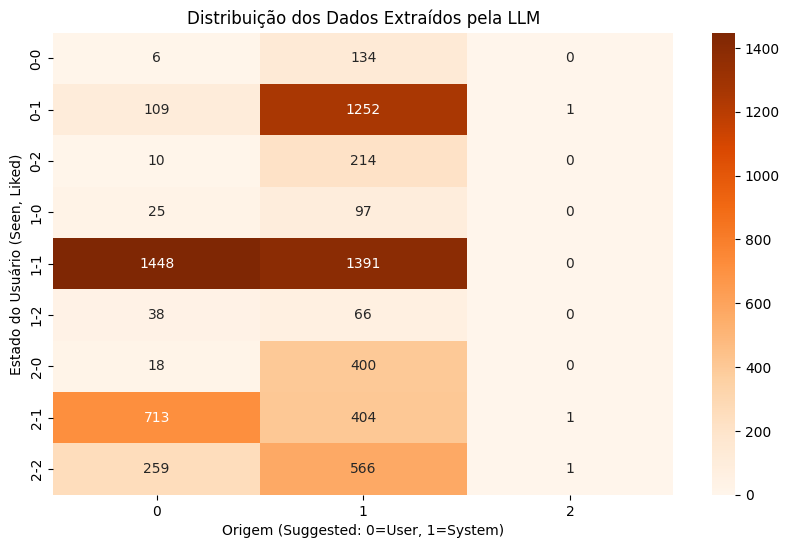

In [44]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def build_llm_interaction_matrix(responses_list):
    """
    Constrói a matriz de contagem a partir das strings brutas da LLM.
    Formato esperado: "Titulo####Attitude####Suggested####Seen"
    
    Mapeamento:
    - LLM Attitude  -> Coluna 'Liked'
    - LLM Suggested -> Coluna 'Suggested'
    - LLM Seen      -> Coluna 'Seen'
    """
    rows = []

    for response in responses_list:
        if not isinstance(response, str):
            continue
            
        # Divide a resposta em linhas (cada linha é um filme)
        lines = response.strip().split('\n')
        
        for line in lines:
            # Pula linhas vazias
            if not line.strip(): 
                continue
                
            try:
                # Quebra pelo delimitador ####
                parts = line.split('####')
                
                # O formato novo tem 4 partes: Title, Attitude, Suggested, Seen
                if len(parts) >= 4:
                    # attitude = parts[1] (Liked)
                    # suggested = parts[2]
                    # seen = parts[3]
                    
                    liked = int(parts[1].strip())
                    sugg = int(parts[2].strip())
                    seen = int(parts[3].strip())
                    
                    rows.append({
                        'Suggested': sugg,
                        'Seen': seen,
                        'Liked': liked
                    })
            except (ValueError, IndexError):
                # Ignora linhas mal formatadas ou erros de conversão int
                continue

    # Cria DataFrame base
    df = pd.DataFrame(rows)

    if df.empty:
        print("⚠️ Nenhum dado extraído. Verifique o formato da string.")
        return df, None, None

    # Coluna auxiliar para contagem
    df['Count'] = 1

    # 1. Matriz de Contagem (Lista Mestra)
    count_matrix = df.groupby(['Suggested', 'Seen', 'Liked'])['Count'].sum().reset_index()
    count_matrix = count_matrix.sort_values(by='Count', ascending=False)

    # 2. Matriz Visual (Pivot Table)
    pivot_matrix = df.pivot_table(
        index=['Seen', 'Liked'], 
        columns='Suggested', 
        values='Count', 
        aggfunc='sum',
        fill_value=0
    )

    return df, count_matrix, pivot_matrix

# --- EXECUÇÃO ---
# Certifique-se de que 'responses_list' contém as strings geradas pelo novo prompt
df_llm_raw, counts_llm, matrix_llm = build_llm_interaction_matrix(responses_list)

print("="*60)
print("TOP 10 COMBINAÇÕES (DADOS DA LLM)")
print("="*60)
if counts_llm is not None:
    print(counts_llm.head(10))

    print("\n" + "="*60)
    print("MATRIZ DETALHADA LLM (Seen/Liked vs Suggested)")
    print("Legenda: Suggested=1 (Sistema), Seen=0 (Não viu), Liked=1 (Gostou)")
    print("="*60)
    print(matrix_llm)

    # --- PLOT OPCIONAL ---
    plt.figure(figsize=(10, 6))
    sns.heatmap(matrix_llm, annot=True, fmt='d', cmap='Oranges') # Cor diferente para distinguir
    plt.title("Distribuição dos Dados Extraídos pela LLM")
    plt.ylabel("Estado do Usuário (Seen, Liked)")
    plt.xlabel("Origem (Suggested: 0=User, 1=System)")
    plt.show()

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def analisar_matriz_flags(dataset):
    """
    Gera uma matriz de contagem para todas as combinações de flags:
    Suggested (0,1,2), Seen (0,1,2), Liked (0,1,2).
    """
    rows = []

    for conv in dataset:
        mentions = conv.get('movieMentions', {})
        if not mentions:
            continue
            
        # --- CORREÇÃO DE SEGURANÇA ---
        # Garante que se for lista [], vira dicionário {}
        init_q = conv.get('initiatorQuestions', {})
        if isinstance(init_q, list): init_q = {}
        
        resp_q = conv.get('respondentQuestions', {})
        if isinstance(resp_q, list): resp_q = {}
        # -----------------------------

        for mid in mentions.keys():
            # Extrai as flags. Usamos -1 para indicar "Não presente/Nulo"
            
            # O get(mid, {}) agora é seguro porque resp_q é garantidamente dict
            sugg = resp_q.get(mid, {}).get('suggested', -1)
            
            seen = init_q.get(mid, {}).get('seen', -1)
            liked = init_q.get(mid, {}).get('liked', -1)

            rows.append({
                'Suggested': sugg,
                'Seen': seen,
                'Liked': liked
            })

    # Cria DataFrame
    df = pd.DataFrame(rows)

    if df.empty:
        print("⚠️ Nenhum dado encontrado com as chaves especificadas.")
        return df, None, None

    # 1. Tabela Completa Agrupada
    count_matrix = df.groupby(['Suggested', 'Seen', 'Liked']).size().reset_index(name='Contagem')
    count_matrix = count_matrix.sort_values(by='Contagem', ascending=False)

    # 2. Matriz Visual (Pivot Table)
    pivot_matrix = df.pivot_table(
        index=['Seen', 'Liked'], 
        columns='Suggested', 
        aggfunc='size', 
        fill_value=0
    )

    return df, count_matrix, pivot_matrix

# --- EXECUÇÃO ---
df_raw, df_counts, matrix_view = analisar_matriz_flags(test_data)

print("="*60)
print("TOP 10 COMBINAÇÕES MAIS FREQUENTES")
print("="*60)
if df_counts is not None:
    print(df_counts.head(10))

    print("\n" + "="*60)
    print("MATRIZ DETALHADA (Seen/Liked vs Suggested)")
    print("Legenda: -1 indica ausência da flag")
    print("="*60)
    # display(matrix_view) # Use se estiver no Jupyter
    print(matrix_view)


#         Suggested  Seen  Liked  Count
# 4           0     1      1   1477
# 13          1     1      1   1346
# 10          1     0      1   1286
# 17          1     2      2    678
# 7           0     2      1    516
# 8           0     2      2    368
# 16          1     2      1    355
# 15          1     2      0    304
# 11          1     0      2    226
# 14          1     1      2    134

TOP 10 COMBINAÇÕES MAIS FREQUENTES
    Suggested  Seen  Liked  Contagem
12          0     1      1      2087
22          1     1      1      1914
19          1     0      1      1405
20          1     0      2       372
26          1     2      2       300
21          1     1      0       130
23          1     1      2       126
16          0     2      2       116
9           0     0      1       116
18          1     0      0       101

MATRIZ DETALHADA (Seen/Liked vs Suggested)
Legenda: -1 indica ausência da flag
Suggested   -1     0     1
Seen Liked                
-1   -1     28    17    45
 0    0      0     5   101
      1     26   116  1405
      2      3    55   372
 1    0      4    40   130
      1     73  2087  1914
      2      2    69   126
 2    0      0     2    40
      1      0    18    45
      2      3   116   300


In [391]:
#SALVAR!!!!!!
import pickle

with open("./variables/responses_list.pkl", "wb") as f:
    pickle.dump(responses_list, f)



In [72]:
#ABRIR!!!!!!
with open("./variables/responses_list.pkl", "rb") as f:
    responses_list = pickle.load(f)

In [21]:
responses_list

['Super Troopers (2001)####2\nAmerican Pie (1999)####2\nPolice Academy (1984)####1\nPolice Academy 2: Their First Assignment (1985)####1\nLethal Weapon (1987)####1',
 'A Nightmare on Elm Street (1984)####2\nThe Last House on the Left (1972)####2\nAnnabelle (2014)####2\nThe Forest (2016)####2',
 'Easy A (2010)####2\nThe Waterboy (1998)####1\nIt (2017)####0\nAvengers: Infinity War (2018)####0\nThe Black Panthers: Vanguard of the Revolution (2015)####0\nClick (2006)####0',
 'Avengers: Infinity War (2018)####1\nThe Avengers (2012)####2\nIron Man 2 (2010)####1\nIt (2017)####1',
 'Avengers: Infinity War (2018)####2\nSpider-Man (2002)####2\nIron Man (2008)####2\nX-Men: First Class (2011)####1',
 'Avengers: Infinity War (2018)####1\nIt (1990)####1\nThe Exorcist (1973)####0',
 'It (1990)####0\nIt (2017)####0\nThe Exorcist  (1973)####2\nThe Last Exorcism (2010)####1',
 "Click (2006)####0\nThe Mask (1988)####2\nSon of the Mask (2005)####0\nYou Don't Mess with the Zohan (2008)####2",
 'Avengers: I

In [73]:
from collections import Counter

def contar_atitudes_llm(responses_list):
    all_attitudes = []
    
    for response in responses_list:
        if not isinstance(response, str): continue
        
        # Quebra as linhas dentro de cada string da lista
        lines = response.strip().split('\n')
        
        for line in lines:
            try:
                # O formato é Titulo####Atitude####Suggested####Seen
                parts = line.split('####')
                if len(parts) >= 2:
                    attitude = int(parts[1])
                    all_attitudes.append(attitude)
            except (ValueError, IndexError):
                continue
                
    counts = Counter(all_attitudes)
    
    print("=== Distribuição de Atitudes (LLM) ===")
    print(f"Total de itens extraídos: {len(all_attitudes)}")
    for k in sorted(counts.keys()):
        print(f"Atitude {k}: {counts[k]} itens ({counts[k]/len(all_attitudes):.1%})")

# Execute passando sua lista de respostas da LLM
contar_atitudes_llm(responses_list)

=== Distribuição de Atitudes (LLM) ===
Total de itens extraídos: 5969
Atitude -2: 8 itens (0.1%)
Atitude -1: 231 itens (3.9%)
Atitude 0: 608 itens (10.2%)
Atitude 1: 2836 itens (47.5%)
Atitude 2: 2286 itens (38.3%)


#### Normalizar Atitudes

In [101]:
def normalizar_scores_llm(lista_respostas):
    """
    Processa a lista de saídas da LLM aplicando as regras:
    1. Remove linhas com score -1 ou -2 (Negativos).
    2. Transforma scores 0, 1 e 2 em 1 (Positivos unificados).
    
    Retorna:
    --------
    list: Lista com o mesmo tamanho, mas com strings filtradas e normalizadas.
    """
    lista_processada = []

    for resposta in lista_respostas:
        linhas_novas = []
        
        # Divide a string em linhas para processar cada filme
        for linha in resposta.split('\n'):
            # Verificação básica de formato
            if '####' in linha:
                partes = linha.split('####')
                
                # Garante que temos título e score
                if len(partes) >= 2:
                    titulo = partes[0].strip()
                    try:
                        score_original = int(partes[1].strip())
                        
                        # REGRA 1: Remover negativos
                        if score_original < 1:
                            continue
                        
                        # REGRA 2: Transformar 0, 1 e 2 em 1
                        # Se passou pelo filtro acima, é >= 0, então vira 1.
                        linhas_novas.append(f"{titulo}####1")
                        
                    except ValueError:
                        continue # Pula se o score não for número
        
        # Reconstrói a string com quebras de linha
        lista_processada.append('\n'.join(linhas_novas))
        
    return lista_processada


In [75]:

# Executando a função
responses_list_v2 = normalizar_scores_llm(responses_list)

# Printando o resultado (pode copiar daqui)
print(responses_list_v2)

['Super Troopers (2001)####1\nAmerican Pie (1999)####1\nPolice Academy (1984)####1\nPolice Academy 2: Their First Assignment (1985)####1\nLethal Weapon (1987)####1', 'A Nightmare on Elm Street (1984)####1\nThe Last House on the Left (1972)####1\nAnnabelle (2014)####1\nThe Forest (2016)####1', 'Easy A (2010)####1\nThe Waterboy (1998)####1', 'Avengers: Infinity War (2018)####1\nThe Avengers (2012)####1\nIron Man 2 (2010)####1\nIt (2017)####1', 'Avengers: Infinity War (2018)####1\nSpider-Man (2002)####1\nIron Man (2008)####1\nX-Men: First Class (2011)####1', 'Avengers: Infinity War (2018)####1\nIt (1990)####1', 'The Exorcist  (1973)####1\nThe Last Exorcism (2010)####1', "The Mask (1988)####1\nYou Don't Mess with the Zohan (2008)####1", 'Avengers: Infinity War (2018)####1\nClick (2006)####1\nThe Exorcist (1973)####1\nIron Man (2008)####1\nSpider-Man 3 (2007)####1', 'Avengers: Infinity War (2018)####1\nIron Man (2008)####1\nSpider-Man 3 (2007)####1\nIt (2017)####1', 'Avengers: Infinity War 

In [102]:
import pandas as pd


test_data_llm = responses_list_to_df(responses_list_v2)
print(test_data_llm.head(7))
print(test_data_llm.shape)

#(5730, 3)

   conversationId                                       movieTitle  rating
0               0                            Super Troopers (2001)       1
1               0                              American Pie (1999)       1
2               0                            Police Academy (1984)       1
3               0  Police Academy 2: Their First Assignment (1985)       1
4               0                             Lethal Weapon (1987)       1
5               1                 A Nightmare on Elm Street (1984)       1
6               1                The Last House on the Left (1972)       1
(5122, 3)


#### Fuzzy Match

In [103]:


extracted_ids_list = ids_dataset_fuzzy(test_data, responses_list_v2)
extracted_ids_list

⚙️ Processando Extração de Entidades (Fuzzy Match)...
✅ Processamento concluído! 1342 conversas mapeadas.


[{'101794', '111776', '134643', '151656', '94688'},
 {'118338', '125431', '132562', '77161'},
 {'138780', '90253'},
 {'114756', '187028', '205163', '78418'},
 {'154513', '205163', '99583', '99896'},
 {'187028', '205163'},
 {'150640', '76012'},
 {'108426', '79851'},
 {'165531', '205163', '76012', '78874', '99583'},
 {'165531', '187028', '205163', '99583'},
 {'205163', '78874', '99583'},
 {'103896', '205163', '78874', '99910'},
 {'177921', '187028', '205163', '76012'},
 {'127673', '150352', '84363'},
 {'136632', '205163', '78874', '99583'},
 {'120349', '130591', '159090', '185171', '77161'},
 {'118338', '144779', '158950', '177915', '205430', '76279'},
 {'105589', '205163', '78874'},
 {'130591', '139961', '78186', '80235'},
 {'112346', '161313', '170119', '204794', '204974'},
 {'125118', '160007', '181952', '85159', '90253'},
 {'187028', '204334', '205163', '78874'},
 {'161756', '205163', '77161', '84001'},
 {'108426', '178472', '181301', '90253'},
 {'134643', '78186', '78874'},
 {'11051

#### Comparação Extração LLM x Dataset Original

In [104]:


# --- EXECUÇÃO ---

try:
    medias, listas_completas = comparar_orig_extracao(test_data, responses_list_v2)

    print("="*40)
    print("📊 RESULTADOS GERAIS DE EXTRAÇÃO")
    print("="*40)
    print(f"🎯 Jaccard Médio:   {medias['jaccard']:.4f}")
    print(f"🎯 Precision Média: {medias['precision']:.4f}  (Robustez contra alucinação)")
    print(f"🎯 Recall Médio:    {medias['recall']:.4f}     (Capacidade de encontrar filmes)")
    print("-" * 40)
    
    print("\nExemplos (5 primeiros):")
    for i in range(5):
        print(f"Conv {i+1}: J={listas_completas['jaccard'][i]:.2f}, "
              f"P={listas_completas['precision'][i]:.2f}, "
              f"R={listas_completas['recall'][i]:.2f}")

except Exception as e:
    print(f"Erro na execução: {e}")




📊 RESULTADOS GERAIS DE EXTRAÇÃO
🎯 Jaccard Médio:   0.7509
🎯 Precision Média: 0.8990  (Robustez contra alucinação)
🎯 Recall Médio:    0.8066     (Capacidade de encontrar filmes)
----------------------------------------

Exemplos (5 primeiros):
Conv 1: J=0.80, P=0.80, R=1.00
Conv 2: J=1.00, P=1.00, R=1.00
Conv 3: J=0.33, P=1.00, R=0.33
Conv 4: J=0.50, P=0.75, R=0.60
Conv 5: J=0.80, P=1.00, R=0.80


## Treinamento Modelo

#### EASEr (Embarrassingly Shallow Autoencoders)

##### Treino Base

In [28]:
import numpy as np

class EASE:
    def __init__(self):
        pass

    def fit(self, X, lambda_):
        """
        X: sparse matrix (users × items)
        lambda_: regularization
        """
        self.X = X
        G = (X.T @ X).toarray()

        diag = np.diag_indices(G.shape[0])
        G[diag] += lambda_

        P = np.linalg.inv(G)
        B = P / (-np.diag(P))
        B[diag] = 0

        self.B = B
        self.pred = X @ B


##### Métricas de Avaliação

In [29]:
# CERTO, NAO MUDAR
def recall_at_k(hits, num_gt, k):
    hits_at_k = hits[:k]
    return sum(hits_at_k) / num_gt

# CERTO, NAO MUDAR
def dcg_at_k(hits, k):
    if len(hits) == 1:
        return hits[0]
    k = min(k, len(hits))
    return hits[0] + sum(hits[i] / np.log2(i + 2) for i in range(1, k))

# CERTO, NAO MUDAR
def ndcg_at_k(hits, num_gt, k):
    idea_hits = np.zeros(len(hits), dtype=int)
    idea_hits[:num_gt] = 1
    idea_dcg = dcg_at_k(idea_hits, k)
    dcg = dcg_at_k(hits, k)
    return dcg/idea_dcg


##### Função de Rec

In [30]:
ease = EASE()
ease.fit(train_user_item_sparse, lambda_=500)

import numpy as np

def recommend_user(ease, user, k=10):
    # scores previstos para todos os itens
    scores = ease.pred[user].copy()

    # remover itens que o usuário já consumiu
    user_interactions = ease.X[user].toarray().ravel()
    scores[user_interactions > 0] = -np.inf

    # pegar top-k
    topk = np.argpartition(scores, -k)[-k:]
    topk = topk[np.argsort(scores[topk])[::-1]]  # ordenar

    return topk, scores[topk]


items, scores = recommend_user(ease, user=0, k=10)
print(items)
print(scores)



[1897 5099 2619  750 3498  271 2577 1321 2316 3166]
[0.01914599 0.01295846 0.01267807 0.01138716 0.01106538 0.0106366
 0.00957691 0.00954933 0.00953394 0.00858574]


##### Teste

In [43]:
def get_valid_targets(step_ids, rq, init_q, seen_pool):
    """
    Extrai os itens que servem como Ground Truth (Targets) para avaliação.
    
    Args:
        step_ids (list): Lista de IDs (int) mencionados na mensagem atual.
        rq (dict): RespondentQuestions (metadados de sugestão).
        init_q (dict): InitiatorQuestions (metadados de sentimento/visto).
        seen_pool (set): Conjunto de itens já mencionados na conversa anteriormente.
        
    Returns:
        list: Lista de IDs válidos para serem usados como alvo (Target).
    """
    targets = []
    
    for mid in step_ids:
        mid_str = str(mid)
        
 
        if rq.get(mid_str, {}).get("suggested") != 1: 
            continue

        if init_q.get(mid_str, {}).get('seen') != 0: 
            continue

        if init_q.get(mid_str, {}).get('liked') != 1: 
            continue

        if mid in seen_pool: 
            continue

        targets.append(mid)
        
    return targets

In [46]:
def avaliar_orig(dataset, ease_model, movie_mapper, k_values=[5, 10, 15, 20, 50]):
    """
    Avaliação CRAG Oracle (Baseline):
    Usa Ground Truth para Contexto e Targets, validando o teto de performance do EASE.
    """
    
    # Setup EASE
    W = ease_model.B.copy()
    np.fill_diagonal(W, 0)
    n_items = W.shape[0]
    
    results = {k: {'recalls': [], 'ndcgs': []} for k in k_values}
    
    # Stats para debug
    stats = {
        'turns_evaluated': 0,
        'skipped_no_context': 0,
        'skipped_no_targets': 0
    }
    
    print(f"🔬 Iniciando Avaliação ORACLE... ({len(dataset)} conversas)")
    
    for conv in tqdm(dataset, desc="CRAG Oracle Eval"):
        
        # --- PREPARAÇÃO DE METADADOS (Igual ao seu original) ---
        init_q = conv.get("initiatorQuestions", {})
        if isinstance(init_q, list): init_q = {}
        rq = conv.get("respondentQuestions", {})
        if isinstance(rq, list): rq = {}
        
        mentions = conv.get("movieMentions", {})
        if not mentions: continue
        mention_keys = list(mentions.keys())
        
        # --- RECONSTRUÇÃO DA TIMELINE (Manual, como você queria) ---
        timeline = []
        for msg in conv.get("messages", []):
            text = msg.get("text", "")
            ids_in_msg = [int(mid) for mid in mention_keys if f"@{mid}" in text]
            
            if ids_in_msg:
                sender = msg.get("senderWorkerId")
                timeline.append({
                    "ids": ids_in_msg,
                    "is_rec": (sender == conv.get("respondentWorkerId")),
                    "is_seek": (sender == conv.get("initiatorWorkerId"))
                })
        
        context_pool = set()
        seen_pool = set()
        
        # --- LOOP DE TURNOS ---
        for step in timeline:
            step_ids = step["ids"]
            
            # >>> AQUI ESTÁ A MUDANÇA: Usando a função auxiliar <<<
            if step["is_rec"]:
                
                targets = get_valid_targets(
                    step_ids=step_ids,
                    rq=rq,
                    init_q=init_q,
                    seen_pool=seen_pool
                )
                
                # Validação para rodar inferência
                if targets and context_pool:
                    
                    # 1. Input Mapping
                    input_indices = [movie_mapper[mid] for mid in context_pool if mid in movie_mapper]
                    
                    if input_indices:
                        # 2. Prediction
                        user_vector = np.zeros(n_items, dtype=np.float32)
                        user_vector[input_indices] = 1.0
                        scores = user_vector @ W
                        
                        # 3. Masking (Remove contexto + vistos)
                        mask_ids = seen_pool | context_pool
                        mask_indices = [movie_mapper[mid] for mid in mask_ids if mid in movie_mapper]
                        if mask_indices:
                            scores[mask_indices] = -np.inf
                        
                        # 4. Metrics Setup
                        max_k = max(k_values)
                        top_indices = np.argpartition(scores, -max_k)[-max_k:]
                        top_scores = scores[top_indices]
                        sorted_idx = np.argsort(top_scores)[::-1]
                        top_k_sorted = top_indices[sorted_idx]
                        
                        # 5. Hit Calculation
                        target_indices = {movie_mapper[t] for t in targets if t in movie_mapper}
                        num_gt = len(targets)
                        
                        for k in k_values:
                            hits = np.array([1 if idx in target_indices else 0 for idx in top_k_sorted[:k]])
                            results[k]['recalls'].append(recall_at_k(hits, num_gt, k))
                            results[k]['ndcgs'].append(ndcg_at_k(hits, num_gt, k))
                        
                        stats['turns_evaluated'] += 1
                    else:
                        stats['skipped_no_context'] += 1
                elif not targets:
                    stats['skipped_no_targets'] += 1
                else:
                    stats['skipped_no_context'] += 1

            # Atualiza pool de vistos
            seen_pool.update(step_ids)
            
            # Atualiza Contexto (Input) se for turno do usuário
            if step["is_seek"]:
                for mid in step_ids:
                    mid_str = str(mid)
                    # Input Strict: Apenas Liked=1 entra no contexto
                    if init_q.get(mid_str, {}).get('liked') == 1:
                        context_pool.add(mid)

    # --- PRINTS FINAIS ---
    print("\n" + "="*80)
    print("📊 RESULTADOS: ORACLE BASELINE")
    print("="*80)
    
    header = f"{'Metric':<12}" + "".join([f"K={k:<10}" for k in k_values])
    print(header)
    print("-" * 80)
    
    final_recalls = [np.mean(results[k]['recalls']) if results[k]['recalls'] else 0.0 for k in k_values]
    final_ndcgs = [np.mean(results[k]['ndcgs']) if results[k]['ndcgs'] else 0.0 for k in k_values]
    
    print(f"{'Recall':<12}" + "".join([f"{val:<10.4f}" for val in final_recalls]))
    print(f"{'NDCG':<12}" + "".join([f"{val:<10.4f}" for val in final_ndcgs]))
    print(f"Turnos Avaliados: {stats['turns_evaluated']}")
    print("="*80)
    
    return results

In [47]:
# Execução
results = avaliar_orig(test_data, ease, movie_mapper, k_values=[1, 5, 10, 15, 20, 50])




# ================================================================================
# 📊 CRAG OFFLINE - EASE BASELINE (PAPER EXACT - MULTI K)
# ================================================================================
# Metric      K=1         K=5         K=10        K=15        K=20        K=50        
# --------------------------------------------------------------------------------
# Recall      0.0320    0.0901    0.1382    0.1662    0.1839    0.2654    
# NDCG        0.0339    0.0630    0.0788    0.0863    0.0905    0.1068    


🔬 Iniciando Avaliação ORACLE... (1342 conversas)


CRAG Oracle Eval: 100%|██████████| 1342/1342 [00:17<00:00, 76.49it/s] 


📊 RESULTADOS: ORACLE BASELINE
Metric      K=1         K=5         K=10        K=15        K=20        K=50        
--------------------------------------------------------------------------------
Recall      0.0304    0.0838    0.1331    0.1572    0.1782    0.2396    
NDCG        0.0324    0.0595    0.0758    0.0822    0.0873    0.0998    
Turnos Avaliados: 740


##### Teste Extração LLM

In [48]:
def avaliar_llm(dataset, extracted_ids_list, ease_model, movie_mapper, k_values=[10, 20, 50]):
    """
    Avaliação Definitiva do Pipeline: LLM (Extração) -> EASE (Recomendação).
    Usa get_valid_targets para padronizar o gabarito com a função Oracle.
    """
    
    # 1. Prepara Matriz EASE
    W = ease_model.B.copy()
    np.fill_diagonal(W, 0)
    n_items = W.shape[0]
    
    results = {k: {'recalls': [], 'ndcgs': []} for k in k_values}
    
    stats = {
        'turns_evaluated': 0,
        'skipped_no_context': 0,
        'skipped_no_targets': 0,
        'items_extracted_by_llm': 0
    }
    
    print(f"🔬 Iniciando Avaliação do Pipeline LLM ({len(dataset)} conversas)...")
    
    # Zipa dataset (Ground Truth) com as extrações da LLM
    for conv, llm_recognized_ids in tqdm(zip(dataset, extracted_ids_list), total=len(dataset)):
        
        # --- PREPARAÇÃO DE METADADOS ---
        init_q = conv.get("initiatorQuestions", {})
        if isinstance(init_q, list): init_q = {}
        rq = conv.get("respondentQuestions", {})
        if isinstance(rq, list): rq = {}
        
        mentions = conv.get("movieMentions", {})
        if not mentions: continue
        mention_keys = list(mentions.keys())
        
        # Set de busca rápida para a LLM
        # Garante que estamos comparando strings com strings
        llm_recognized_set = set(map(str, llm_recognized_ids))
        
        context_pool = set()
        seen_pool = set()
        
        seeker_id = conv.get("initiatorWorkerId")
        recommender_id = conv.get("respondentWorkerId")
        
        # --- LOOP DE MENSAGENS ---
        for msg in conv.get("messages", []):
            text = msg.get("text", "")
            sender = msg.get("senderWorkerId")
            
            # Acha IDs nesta mensagem
            ids_found = re.findall(r'@(\d+)', text)
            ids_in_msg = [int(mid) for mid in ids_found if mid in mention_keys]
            
            if not ids_in_msg: continue
            
            # ---------------------------------------------------------
            # TURNO DO USUÁRIO (Input Context)
            # ---------------------------------------------------------
            if sender == seeker_id:
                for mid in ids_in_msg:
                    mid_str = str(mid)
                    
                    # 1. FILTRO DA LLM (O diferencial desta função)
                    # Se a LLM não extraiu, o EASE não vê esse item.
                    if mid_str not in llm_recognized_set:
                        continue
                        
                    # 2. CONDIZÊNCIA (Strict Context: Liked=1)
                    if init_q.get(mid_str, {}).get('liked') == 1:
                        context_pool.add(mid)
                        stats['items_extracted_by_llm'] += 1
                    
                    # Atualiza vistos (independente se gostou ou não)
                    seen_pool.add(mid)

            # ---------------------------------------------------------
            # TURNO DO SISTEMA (Avaliação / Targets)
            # ---------------------------------------------------------
            elif sender == recommender_id:
                
                # >>> AQUI ESTÁ A MUDANÇA: Usando a função auxiliar <<<
                targets = get_valid_targets(
                    step_ids=ids_in_msg,
                    rq=rq,
                    init_q=init_q,
                    seen_pool=seen_pool
                )
                
                # Validações para inferência
                # Precisamos de Contexto (dado pela LLM) E Targets (dado pelo GT)
                if not context_pool:
                    stats['skipped_no_context'] += 1
                    seen_pool.update(ids_in_msg)
                    continue
                    
                if not targets:
                    stats['skipped_no_targets'] += 1
                    seen_pool.update(ids_in_msg)
                    continue

                # --- INFERÊNCIA EASE ---
                input_indices = [movie_mapper[mid] for mid in context_pool if mid in movie_mapper]
                
                if not input_indices:
                    stats['skipped_no_context'] += 1
                    seen_pool.update(ids_in_msg)
                    continue

                user_vector = np.zeros(n_items, dtype=np.float32)
                user_vector[input_indices] = 1.0
                scores = user_vector @ W
                
                # Masking
                mask_ids = seen_pool | context_pool
                mask_indices = [movie_mapper[mid] for mid in mask_ids if mid in movie_mapper]
                if mask_indices:
                    scores[mask_indices] = -np.inf
                
                # Métricas
                max_k = max(k_values)
                top_indices = np.argpartition(scores, -max_k)[-max_k:]
                top_scores = scores[top_indices]
                sorted_idx = np.argsort(top_scores)[::-1]
                top_k_sorted = top_indices[sorted_idx]
                
                # Mapeia targets
                target_indices = {movie_mapper[t] for t in targets if t in movie_mapper}
                num_gt = len(targets)
                
                for k in k_values:
                    hits = np.array([1 if idx in target_indices else 0 for idx in top_k_sorted[:k]])
                    results[k]['recalls'].append(recall_at_k(hits, num_gt, k))
                    results[k]['ndcgs'].append(ndcg_at_k(hits, num_gt, k))
                
                stats['turns_evaluated'] += 1
                seen_pool.update(ids_in_msg)

    # ============================================
    # RELATÓRIO FINAL
    # ============================================
    print("\n" + "="*80)
    print("🚀 RESULTADOS FINAIS: Pipeline LLM + EASE")
    print("="*80)
    
    header = f"{'Metric':<12}" + "".join([f"K={k:<10}" for k in k_values])
    print(header)
    print("-" * 80)
    
    final_recalls = [np.mean(results[k]['recalls']) if results[k]['recalls'] else 0.0 for k in k_values]
    final_ndcgs = [np.mean(results[k]['ndcgs']) if results[k]['ndcgs'] else 0.0 for k in k_values]
    
    print(f"{'Recall':<12}" + "".join([f"{val:<10.4f}" for val in final_recalls]))
    print(f"{'NDCG':<12}" + "".join([f"{val:<10.4f}" for val in final_ndcgs]))
    
    print("\n📊 DIAGNÓSTICO:")
    print(f"Turnos Avaliados: {stats['turns_evaluated']}")
    print(f"Total Itens Contexto (LLM): {stats['items_extracted_by_llm']}")
    print(f"Skipped (Sem Contexto Válido): {stats['skipped_no_context']}")
    print("="*80)
    
    return results, stats

In [49]:
# ============================================
# EXECUÇÃO
# ============================================
results, stats = avaliar_llm(
    dataset=test_data,
    extracted_ids_list=extracted_ids_list,
    ease_model=ease,
    movie_mapper=movie_mapper,
    k_values=[1, 5, 10, 15, 20, 50]
)


# ================================================================================
# 🚀 RESULTADOS FINAIS: Pipeline LLM + EASE (PAPER COMPLIANT)
# ================================================================================
# Metric      K=1         K=5         K=10        K=15        K=20        K=50        
# --------------------------------------------------------------------------------
# Recall      0.0261    0.0803    0.1282    0.1547    0.1765    0.2350    
# NDCG        0.0282    0.0558    0.0717    0.0787    0.0840    0.0958    

# 📊 DIAGNÓSTICO:
# Turnos Avaliados: 710
# Total Itens Contexto (LLM): 2739
# Skipped (Sem Contexto Válido): 1789
# ================================================================================

🔬 Iniciando Avaliação do Pipeline LLM (1342 conversas)...


100%|██████████| 1342/1342 [00:17<00:00, 78.61it/s] 



🚀 RESULTADOS FINAIS: Pipeline LLM + EASE
Metric      K=1         K=5         K=10        K=15        K=20        K=50        
--------------------------------------------------------------------------------
Recall      0.0261    0.0803    0.1282    0.1547    0.1765    0.2350    
NDCG        0.0282    0.0558    0.0717    0.0787    0.0840    0.0958    

📊 DIAGNÓSTICO:
Turnos Avaliados: 710
Total Itens Contexto (LLM): 2739
Skipped (Sem Contexto Válido): 1789


## Re-Ranqueamento

### Análise Contexto

### Recomendações LLM  $\cap$  Recomendações EASE